https://colab.research.google.com/drive/1_G9zJ_7_JdNRFpZuwmg3XtFq7Sk7IEFM

In [0]:
!apt-get install python-opengl -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (469 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...


In [0]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.2 [783 kB]
Fetched 783 kB in 1s (713 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 133677 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.2_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.2) ...
Setting up xvfb (2:1.19.6-1ubuntu4.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
!pip install pyvirtualdisplay

  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Stored in directory: /root/.cache/pip/wheels/41/22/19/af15ef6264c58b625a82641ed7483ad05e258fbd8925505227
Successfully built pyvirtualdisplay EasyProcess


In [0]:
!pip install piglet

    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 92kB 8.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/c7/59/a5/5bd1a35a4a4596714c4c7925a1751e7b1580b6ced363fd7969
Successfully built piglet


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Observation space: Box(4,)
Action space: Discrete(2)


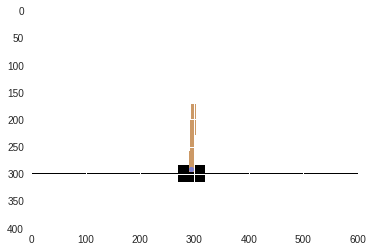

In [0]:
import gym
env = gym.make("CartPole-v0")
env.reset()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
plt.imshow(env.render(mode='rgb_array'))
state_size = env.observation_space.shape[0] 
action_size = env.action_space.n


In [0]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

Using TensorFlow backend.


In [0]:
model=Sequential()
model.add(Dense(24,input_dim=state_size,activation='relu'))
model.add(Dense(24,activation='relu'))
model.add(Dense(2,activation='linear'))
model.compile(loss='mse',optimizer=Adam(lr=0.01))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
memory = deque(maxlen=1000)
epsilon = 1
epsilon_min=0.01
epsilon_decay=0.995
memory = []
gamma = 0.9
batch_size = 32

In [0]:
def replay(model, batch_size,epsilon):
    epsilon_min = 0.01
    epsilon_decay = 0.995
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = (reward + gamma *np.amax(model.predict(next_state)[0]))
        new_action_value = model.predict(state)
        new_action_value[0][action] = target
        model.fit(state,new_action_value, epochs=1, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    return model,epsilon

In [0]:
episodes=200
maxsteps=200
score_list = []
for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for step in range(maxsteps):
        if np.random.rand()<=epsilon:
            action=env.action_space.sample()
        else:
            action = np.argmax(model.predict(state)[0])
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("episode: {}, score: {}, exp prob: {:.2}".format(e, step, epsilon))
            score_list.append(step)
            break
        if len(memory) > batch_size:
            model,epsilon=replay(model, batch_size,epsilon)